# Contrastive Explanation Method
[Alibi MNIST Reference Code](https://github.com/SeldonIO/alibi/blob/524d786c81735ed90da2d2c68851c1145fa1b595/examples/cem_mnist.ipynb)

Copyright 2020, Denis Rothman, MIT License. Added training options form and auto-encoder options form. Added Alibi installation.


In [56]:
#@title Install Alibi
try:
  import alibi
except:
  !pip install alibi

In [48]:
#@title Import modules
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CEM

x_train shape: (60000, 28, 28) y_train shape: (60000,)


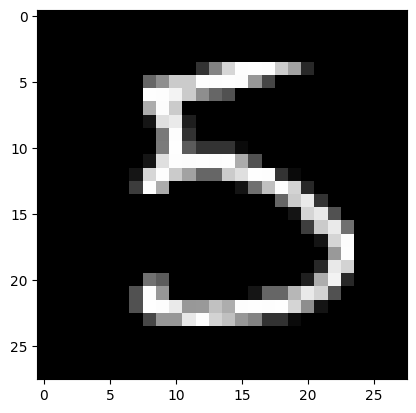

In [57]:
#@title Load and prepare MNIST Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[15]);

In [58]:
#@title Preparing data: scaling the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_test[1])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.45490196 0.49019608
  0.6705882

In [59]:
#@title Preparing data: shaping the data
print("Initial Shape",x_test.shape)
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)

Initial Shape (10000, 28, 28)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


In [60]:
#@title Preparing data: categorizing the data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

y_train shape: (60000, 10) y_test shape: (10000, 10)


In [61]:
#@title Create and train CNN model
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn


In [64]:
train_cnn = 'yes' #@param ["yes","no"]
if train_cnn=="yes":
  cnn = cnn_model()
  cnn.summary()
  cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
  cnn.save('mnist_cnn_jn.h5')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                     

2023-11-17 00:26:28.488267: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_14/kernel/Assign' id:2710 op device:{requested: '', assigned: ''} def:{{{node dense_14/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_14/kernel, dense_14/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [65]:
#@title Load and test accuracy on test dataset
cnn = load_model('mnist_cnn_jn.h5')
cnn.summary()
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

2023-11-17 00:27:19.668010: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_14_1/kernel/Assign' id:3297 op device:{requested: '', assigned: ''} def:{{{node dense_14_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_14_1/kernel, dense_14_1/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                     

2023-11-17 00:27:19.871170: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_14_1/kernel/v/Assign' id:3553 op device:{requested: '', assigned: ''} def:{{{node dense_14_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_14_1/kernel/v, dense_14_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-17 00:27:20.037306: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_9/mul' id:3454 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_15_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runni

Test accuracy:  0.9777


In [66]:
#@title Define and train autoencoder
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [67]:
train_auto_encoder = 'yes' #@param ["yes","no"]

if train_auto_encoder=="yes":
  ae = ae_model()
  ae.summary()
  ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
  ae.save('mnist_ae_jn.h5', save_format='h5')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 1)         145       
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 16)        160       
                                                           

2023-11-17 00:27:38.594327: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/conv2d_19/bias/v/Assign' id:4035 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/conv2d_19/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/conv2d_19/bias/v, training_6/Adam/conv2d_19/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-17 00:27:47.464035: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_10/mul' id:3801 op device:{requested: '', assigned: ''} def:{{{node loss_10/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_10/mul/x, loss_10/conv2d_21_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

2023-11-17 00:28:25.925784: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_17_1/bias/Assign' id:4191 op device:{requested: '', assigned: ''} def:{{{node conv2d_17_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_17_1/bias, conv2d_17_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 1)         145       
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 16)        160       
                                                           

2023-11-17 00:28:26.191277: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_21_1/bias/v/Assign' id:4503 op device:{requested: '', assigned: ''} def:{{{node conv2d_21_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_21_1/bias/v, conv2d_21_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-17 00:28:26.389663: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_21_1/BiasAdd' id:4284 op device:{requested: '', assigned: 

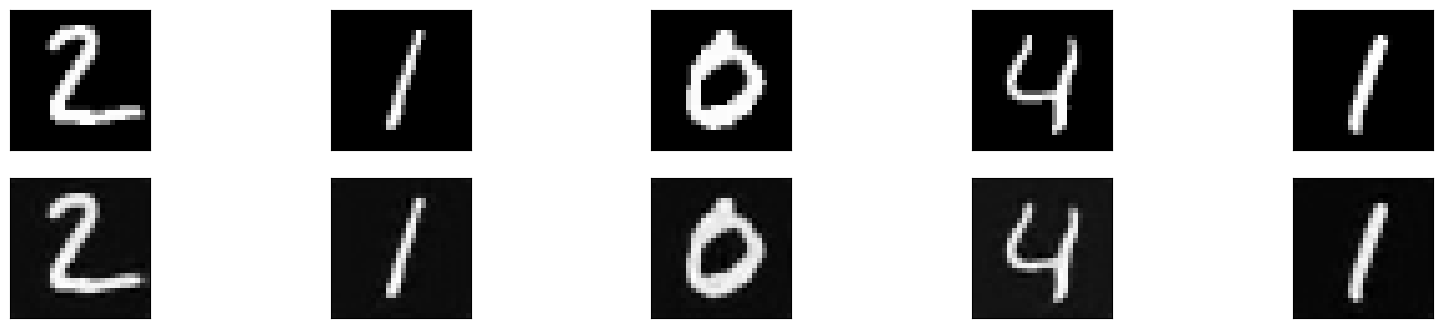

In [68]:
#@title Compare original with decoded images
ae = load_model('mnist_ae_jn.h5')
ae.summary()
decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [69]:
#@title Generate contrastive explanation with pertinent negative
#Explained instance
idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape)

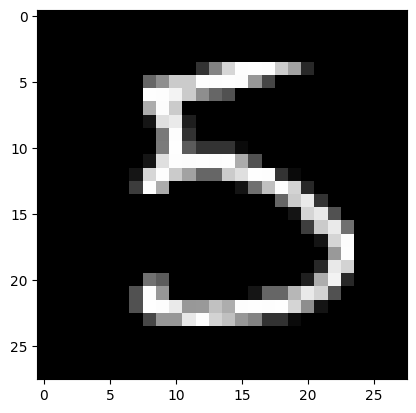

In [70]:
plt.imshow(X.reshape(28, 28));

In [71]:
#@title Model prediction
cnn.predict(X).argmax(), cnn.predict(X).max()

2023-11-17 00:28:36.921931: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_15_1/Softmax' id:3345 op device:{requested: '', assigned: ''} def:{{{node dense_15_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_15_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


(5, 0.99999976)

In [72]:
#@title CEM parameters
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative, 
                  # so positive/negative perturbations imply adding/removing features

In [75]:
#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.reset_default_graph()
#@title initialize CEM explainer and explain instance
with tf.compat.v1.Session() as sess:
    cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
            gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
            c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

2023-11-17 00:29:12.906889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 00:29:12.906918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-17 00:29:13.001934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2350652036516351333


FailedPreconditionError: Graph execution error:

Detected at node 'model_7_2/conv2d_15/Conv2D/ReadVariableOp' defined at (most recent call last):
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/runpy.py", line 87, in _run_code
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 737, in start
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/events.py", line 80, in _run
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in process_one
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    File "/var/folders/0t/h6nl8qcn6pb26ncy0931s09r0000gp/T/ipykernel_45832/4195868431.py", line 6, in <module>
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/alibi/explainers/cem.py", line 107, in __init__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
Node: 'model_7_2/conv2d_15/Conv2D/ReadVariableOp'
Detected at node 'model_7_2/conv2d_15/Conv2D/ReadVariableOp' defined at (most recent call last):
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/runpy.py", line 87, in _run_code
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 737, in start
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/events.py", line 80, in _run
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in process_one
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    File "/var/folders/0t/h6nl8qcn6pb26ncy0931s09r0000gp/T/ipykernel_45832/4195868431.py", line 6, in <module>
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/alibi/explainers/cem.py", line 107, in __init__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
    File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
Node: 'model_7_2/conv2d_15/Conv2D/ReadVariableOp'
2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable conv2d_15_1/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/conv2d_15_1/kernel)
	 [[{{node model_7_2/conv2d_15/Conv2D/ReadVariableOp}}]]
	 [[model_7_2/dense_15/Softmax/_3]]
  (1) FAILED_PRECONDITION: Could not find variable conv2d_15_1/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/conv2d_15_1/kernel)
	 [[{{node model_7_2/conv2d_15/Conv2D/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'model_7_2/conv2d_15/Conv2D/ReadVariableOp':
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/runpy.py", line 197, in _run_module_as_main
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/runpy.py", line 87, in _run_code
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 737, in start
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/asyncio/events.py", line 80, in _run
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in process_one
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
  File "/var/folders/0t/h6nl8qcn6pb26ncy0931s09r0000gp/T/ipykernel_45832/4195868431.py", line 6, in <module>
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/alibi/explainers/cem.py", line 107, in __init__
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 690, in wrapper
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 331, in converted_call
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 690, in wrapper
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 331, in converted_call
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 1183, in convolution_v2
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 1316, in convolution_internal
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 2790, in _conv2d_expanded_batch
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1377, in conv2d
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 778, in _apply_op_helper
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 551, in _ExtractInputsAndAttrs
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 698, in convert_to_tensor
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 234, in convert
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 2315, in _dense_var_to_tensor
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1557, in _dense_var_to_tensor
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 632, in value
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 793, in _read_variable_op
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 783, in read_and_set_handle
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 547, in read_variable_op
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2657, in _create_op_internal
  File "/Users/mkuzlu/anaconda3/envs/Pyyhon_39_TAI/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1161, in from_node_def


In [19]:
#@title Pertinent negative
print('Pertinent negative prediction: {}'.format(explanation.PN_pred))
plt.imshow(explanation.PN.reshape(28, 28));

NameError: name 'explanation' is not defined

In [23]:
#@title Generate pertinent positive
mode = 'PP'

In [24]:
#@title initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

RuntimeError: The Session graph is empty. Add operations to the graph before calling run().

In [25]:
#@title Pertinent positive
print('Pertinent positive prediction: {}'.format(explanation.PP_pred))
plt.imshow(explanation.PP.reshape(28, 28));

NameError: name 'explanation' is not defined